# Hackathon
First Ascend Pro Hackathon!
Link to problem description and datasets can be found here: (https://datahack.analyticsvidhya.com/contest/ascend-pro-assessment-ml-basics/#ProblemStatement)


# Predicting Critical Disease "Stroke"

## Importing Necessary Libraries & Reading Data

In [1]:
# Data Manipulation & Summarisation
import numpy as np 
from numpy import sqrt, abs, round
import pandas as pd

# debugging imports
from IPython import embed
import pdb

# Data Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
color = sns.color_palette()
# %matplotlib inline

# Regex for working with text features
import re

# Datetime for working with datetime features
from datetime import timedelta, date

# Modules required for statistical tests
from scipy.stats import norm
from scipy.stats import t as t_dist
from scipy.stats import chi2_contingency

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

!pip install mlxtend

In [2]:
# Imports from utils files 
from utils import EDA_category, EDA_numeric, Bivariate_cont_cat, BVA_categorical_plot, TwoSampZ, TwoSampT
import utils

# Reading Test Train & Data Dictionary
train=pd.read_csv('train_AvX1lTZ.csv') 
test=pd.read_csv('test_tERCnnc.csv')
data_dict = pd.read_excel('Data Dictionary.xlsx')
# quick view at data dict


# Exploratory Data Analysis (EDA)


In [3]:
train.shape, test.shape # makes sense that test dataset has one less col (no labels)

((43400, 12), (18601, 11))

### Observing Data Dictionary and a few samples

In [4]:
# Extracting Sample of 3 from the dataset for quick eyeballing
sample_df = pd.DataFrame(train.sample(5).T).reset_index() # transposed, to view each patient as col.
sample_df.shape

(12, 6)

In [5]:
# Renaming index column with Variable Name 
sample_df.rename(columns = {'index':'Variable Name'}, inplace = True)
sample_df

,Variable Name,23192,14618,5715,20149,25226
0,id,37762,68376,25280,58487,30066
1,gender,Female,Male,Female,Female,Female
2,age,57,25,6,45,41
3,hypertension,0,1,0,0,0
4,heart_disease,0,0,0,0,0
5,ever_married,Yes,No,No,Yes,Yes
6,work_type,Private,Private,children,Private,Private
7,Residence_type,Urban,Urban,Urban,Rural,Rural
8,avg_glucose_level,70.04,82.29,83.89,151.89,96.51
9,bmi,42.6,31.6,27.1,36.7,46.5


In [6]:
# Merge Data Dictionary with sample for understanding - very nice to visualize each feature w/ description all in one df
data_sample = data_dict[['Variable Name','Description']].merge(sample_df, how = 'right', on = 'Variable Name')
data_sample = data_sample.drop(['Description'], axis=1)
# data_dict[['Variable Name','Description']].merge(sample_df, how = 'right', on = 'Variable Name')
data_sample

,Variable Name,23192,14618,5715,20149,25226
0,id,37762,68376,25280,58487,30066
1,gender,Female,Male,Female,Female,Female
2,age,57,25,6,45,41
3,hypertension,0,1,0,0,0
4,heart_disease,0,0,0,0,0
5,ever_married,Yes,No,No,Yes,Yes
6,work_type,Private,Private,children,Private,Private
7,Residence_type,Urban,Urban,Urban,Rural,Rural
8,avg_glucose_level,70.04,82.29,83.89,151.89,96.51
9,bmi,42.6,31.6,27.1,36.7,46.5


## Visualizing the important characteristics of a dataset

In [7]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

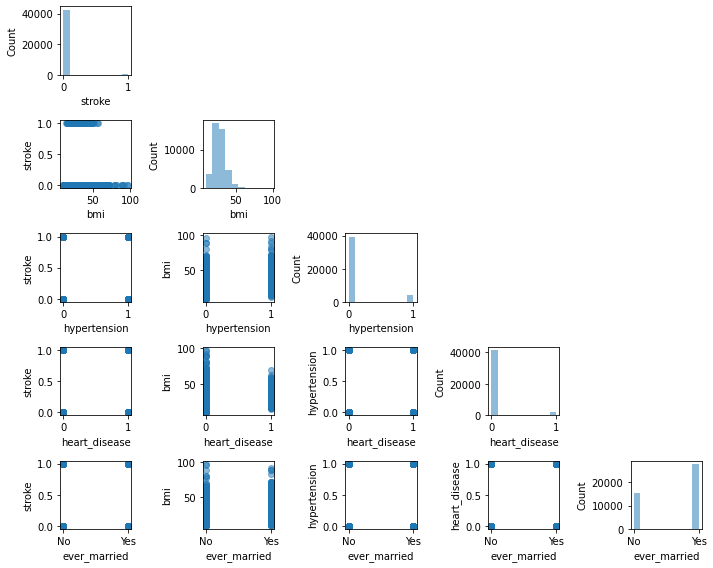

In [8]:
cols = ['stroke', 'bmi', 'hypertension', 'heart_disease', 'ever_married']

scatterplotmatrix(train[cols].values, figsize=(10, 8), 
                  names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

In [9]:
train.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Segregating Categorical & Continuous variables

In [10]:
# Quick Check on number of categories
for c in train.columns:
    n = train[c].nunique()
    print(c) # name of feature
    # print any features that have less than 3 unique values - extract to dict() then print out k and v pairs
    if n <= 3:
        # from IPython import embed; embed()
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
43400
----------
gender
3 [('Female', 25665), ('Male', 17724), ('Other', 11)]
----------
age
104
----------
hypertension
2 [(0, 39339), (1, 4061)]
----------
heart_disease
2 [(0, 41338), (1, 2062)]
----------
ever_married
2 [('No', 15462), ('Yes', 27938)]
----------
work_type
5
----------
Residence_type
2 [('Rural', 21644), ('Urban', 21756)]
----------
avg_glucose_level
12543
----------
bmi
555
----------
smoking_status
3 [('formerly smoked', 7493), ('never smoked', 16053), ('smokes', 6562)]
----------
stroke
2 [(0, 42617), (1, 783)]
----------


## Summary
* id count is 43,400 which is train.shape[0], each patient has a unique ID
* stroke count for no stroke vs stroke also adds up to 43,400

In [11]:
train['age'].value_counts() # perhaps do some kind of binning for age, values too analog in nature.

51.00    738
52.00    721
53.00    701
78.00    698
50.00    694
        ... 
0.48      37
0.40      35
1.00      34
0.16      26
0.08      17
Name: age, Length: 104, dtype: int64

In [12]:
train['avg_glucose_level'].value_counts() # also too anolog - convert to bins.

82.71     19
87.07     18
72.53     18
84.40     17
90.71     17
          ..
202.11     1
121.82     1
138.99     1
152.24     1
160.00     1
Name: avg_glucose_level, Length: 12543, dtype: int64

In [13]:
train['bmi'].value_counts() #  also too anolog - convert to bins.

27.7    271
27.6    267
26.8    266
26.1    265
27.1    260
       ... 
10.1      1
67.0      1
11.2      1
97.6      1
65.2      1
Name: bmi, Length: 555, dtype: int64

In [14]:
# Separate cat and num feats for EDA and feature engineering
target = train['stroke']

target_feat = ['stroke']

cat_feats = ['gender',
             'hypertension',
             'heart_disease',
             'ever_married',
             'work_type',
             'Residence_type',
             'smoking_status']
        
id_feats = ['id']

other_list = cat_feats + id_feats + target_feat
# these number features can be a bit noisy - remember to bin up these feats
num_feats = [x for x in train.columns if x not in other_list]
print(f'Total number/float of features: {num_feats}')

Total number/float of features: ['age', 'avg_glucose_level', 'bmi']


## Univariate Categorical Analysis
Below function was taken from Ankit in the loan prediction lecture, repurposing here for our use.

## Target Variable

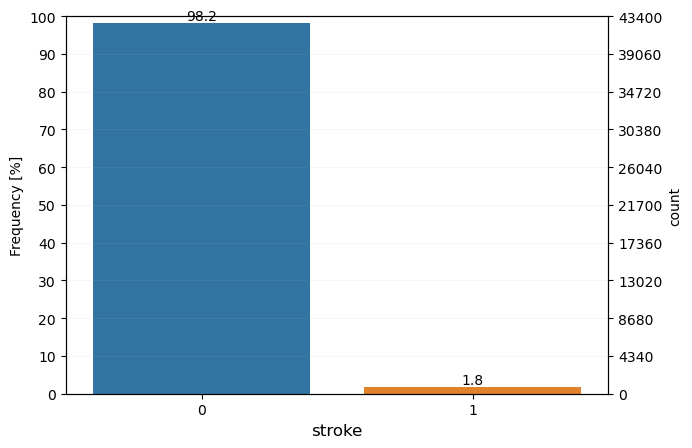

In [15]:
EDA_category(train, ['stroke'])

Clearly, very unbalanced.

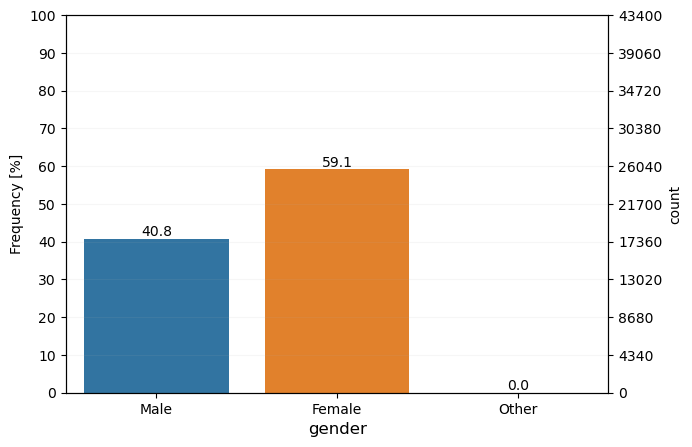

In [16]:
EDA_category(train, ['gender'])

More Female candidates compared to Male.

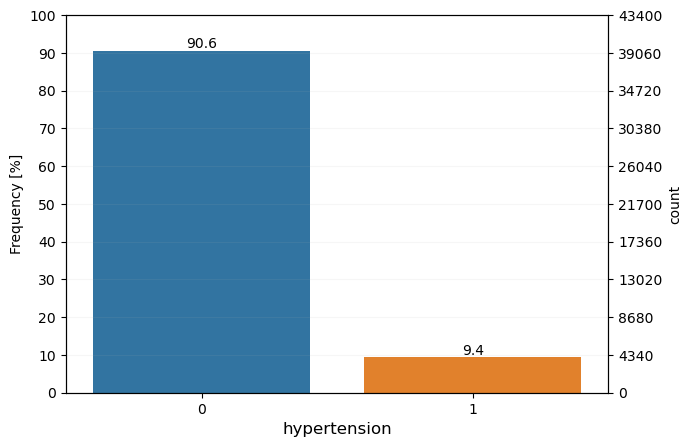

In [17]:
EDA_category(train, ['hypertension'])

Hypertension feature is also unbalanced like that of stroke - may be correlated with stroke.

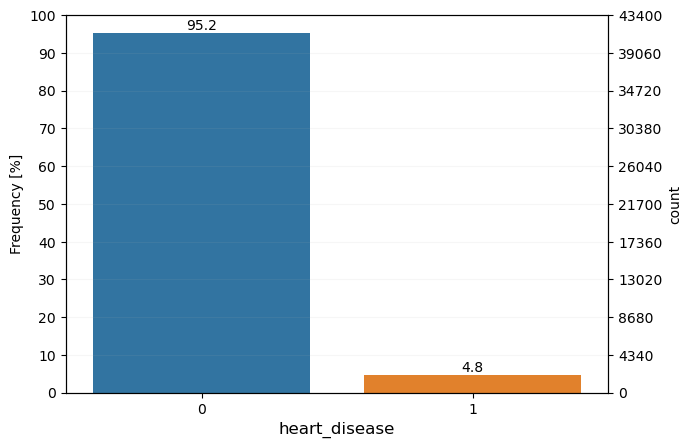

In [18]:
EDA_category(train, ['heart_disease'])

Heart disease is also unbalanced, also a correlation with hypertension and stroke target (dependent var)

## Correlation and Causation? Confounding factor? Spurious Correlation?

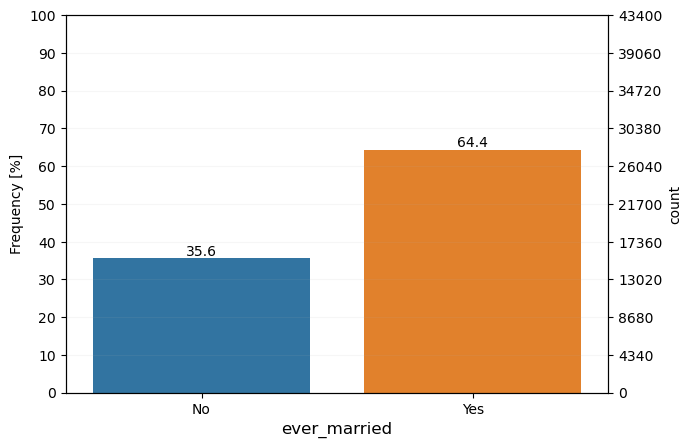

In [19]:
EDA_category(train, ['ever_married'])

LOL being married may lead to hyptertension and finally a stroke? This might be one of those correlation vs causal type of things, where there may be a confounding factor. Maybe just because people who tend to get married and are older and we all know that age strongly correlates with stroke.

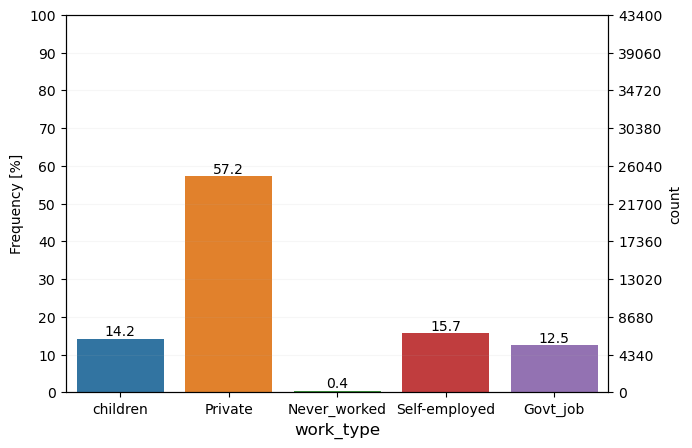

In [20]:
EDA_category(train, ['work_type'])

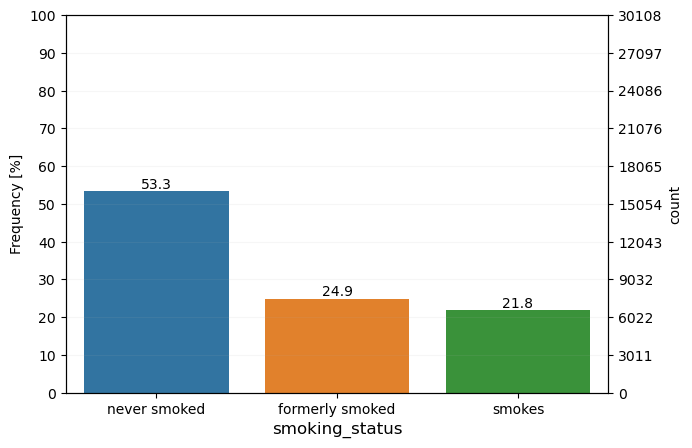

In [21]:
EDA_category(train, ['smoking_status'])

Most people do not smoke, the other ~ half use to smoke or still smoking.

## Univariate Numerical 
Below function was taken from Ankit in the loan prediction lecture, repurposing here for our use.

In [22]:
# displaying number features collected from above cells - we should have 3
num_feats

['age', 'avg_glucose_level', 'bmi']

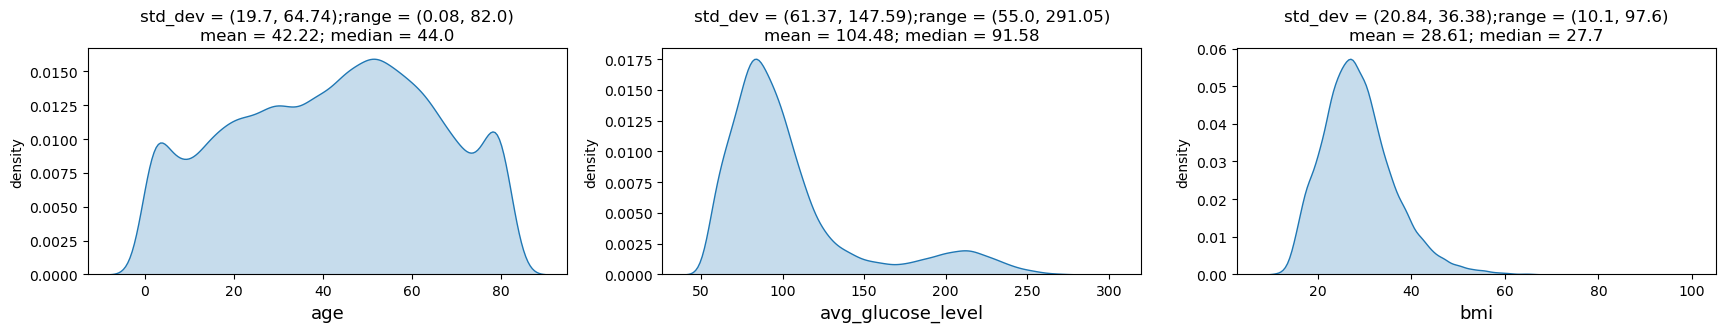

In [23]:
# Disbursed amount & asset cost
EDA_numeric(train,['age','avg_glucose_level', 'bmi'],log = False)

Right off the bat, 'age' feature looks somewhat symmetrical - atleast better than the other two, i.e. mid and right.

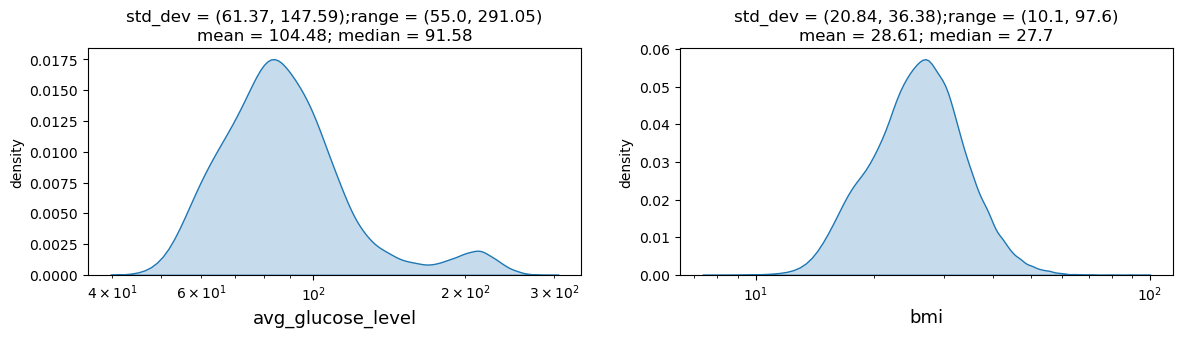

In [24]:
# plot avg_glucose_level and bmi again with log flag to True
EDA_numeric(train,['avg_glucose_level', 'bmi'],log = True)

avg_glucose_level is between 55 - 291.05 and bmi is anywhere from 10.1 - 97.6. Not too many outliers to be concerned with here.

Summary of Num Features
* Note the range that we are seeing above. Perhaps, we can use sklearn's minmaxscaler to transform the dataset.
* Also, note that both avg_glucose_level and bmi are right skwed. Logistic Regression works better with Guassian Dist. Perhaps, we can use some log transform in the preprocessing step before feeding into model.

## Bivariate Analysis Categorical-Categorical
### List of Hypothesis to check under this combination
* Are females more likely to have a stroke than males?
* Does having hypertension lead to having a stroke?
* Does having predispositioned heart disease contribute to stroke?
* Being married may increase stroke?
* Work type may induce stress to have a stroke?
* Where you live and residence type has a part in stroke incidents?
* Smoking may cause a stroke?

Below function was taken from Ankit in the loan prediction lecture, repurposing here for our use.


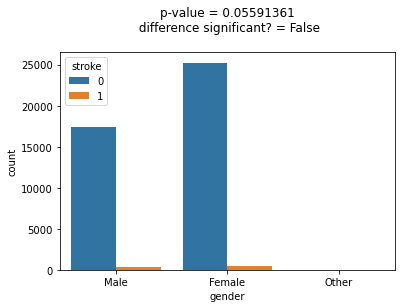

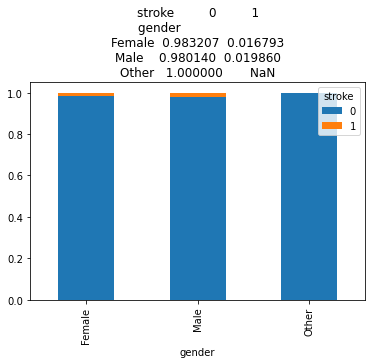

In [25]:
BVA_categorical_plot(train,'stroke','gender')

Between males and females the difference for them to have a stroke is not significant.

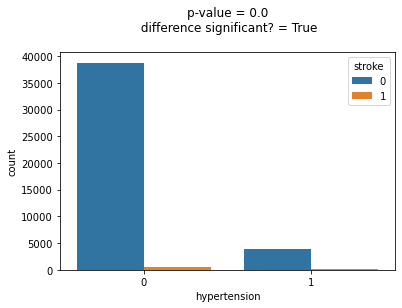

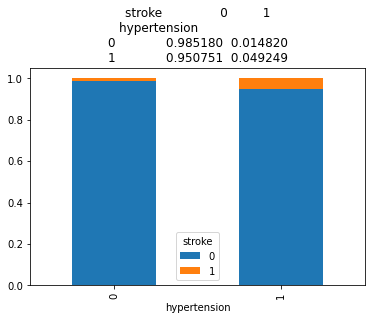

In [26]:
BVA_categorical_plot(train,'stroke','hypertension')

Hyptertension is definitly significant with lower p value.

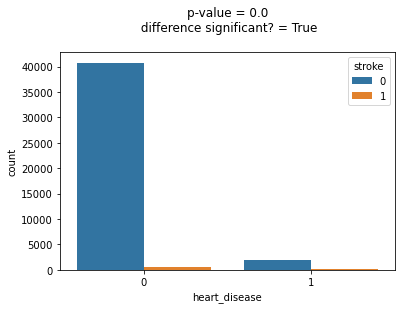

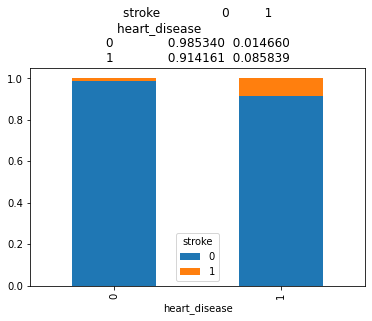

In [27]:
BVA_categorical_plot(train,'stroke','heart_disease')

Heart diseas is also significant with lower p value.

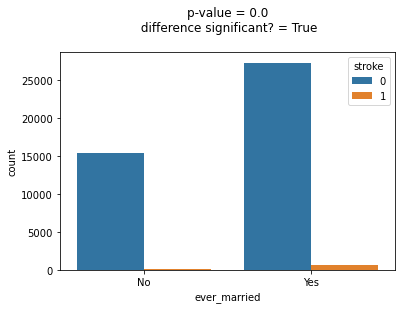

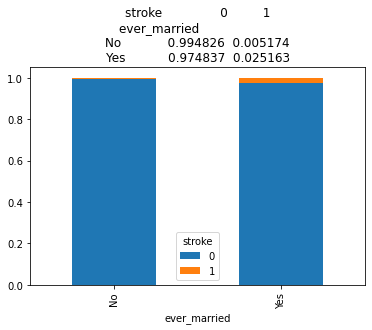

In [28]:
BVA_categorical_plot(train,'stroke','ever_married')

Woah this is hilarious, apparently per the data, being married is significant and increases your chances of having a stroke.

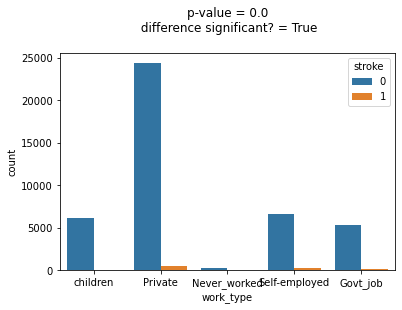

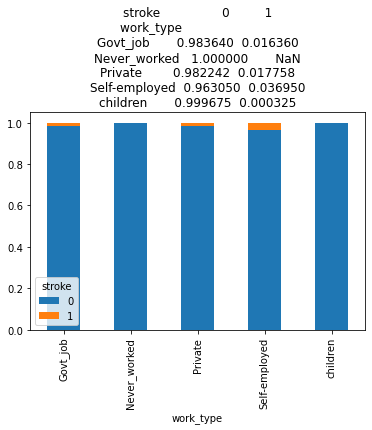

In [29]:
BVA_categorical_plot(train,'stroke','work_type')

As long as one is working, with lower p value, this is significant.

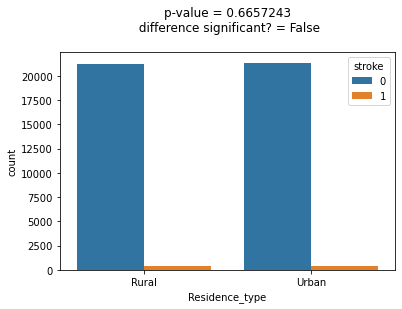

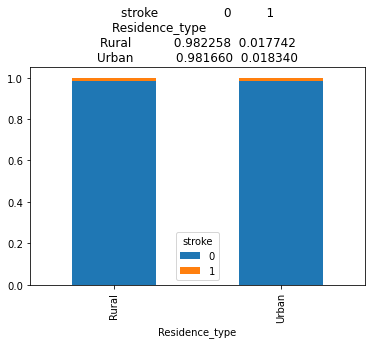

In [30]:
BVA_categorical_plot(train,'stroke','Residence_type')

Residence type is agnostic of stroke and not significant.

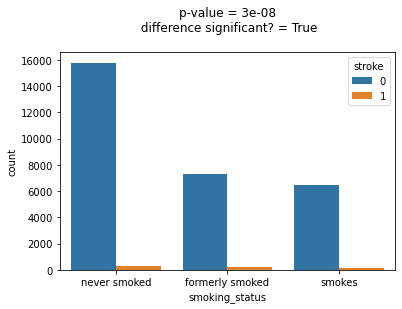

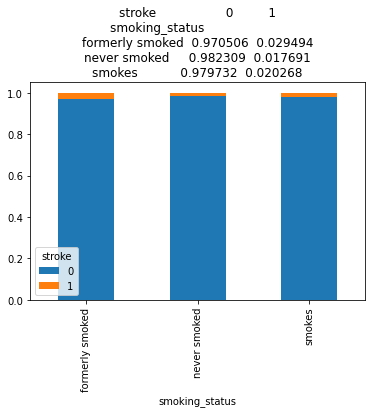

In [31]:
BVA_categorical_plot(train,'stroke','smoking_status')

Smoking feature is statistically significant with stroke target.

## Bivariate Continuous Categorical
Below function was taken from Ankit in the loan prediction lecture, repurposing here for our use.


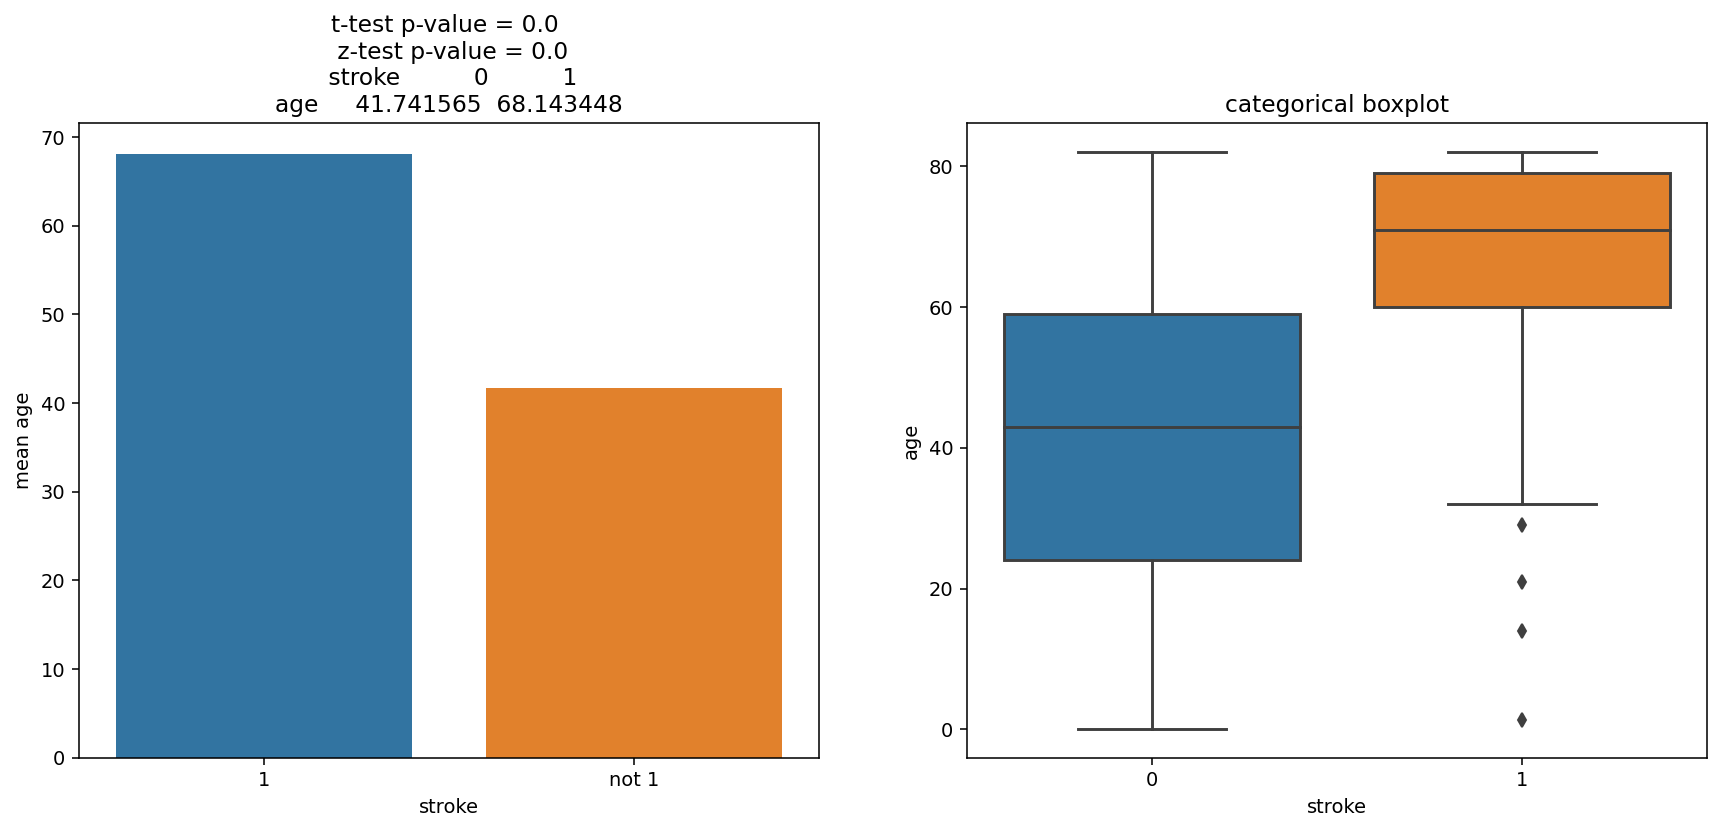

In [32]:
Bivariate_cont_cat(train, 'age', 'stroke', 1)

Age is signficant as we can see from t and z test p values. Older one is the higher the chance of a stroke. HOwever, there are some outliers for younger people having strokes too. Remember to remove these outliers before feeding into model.

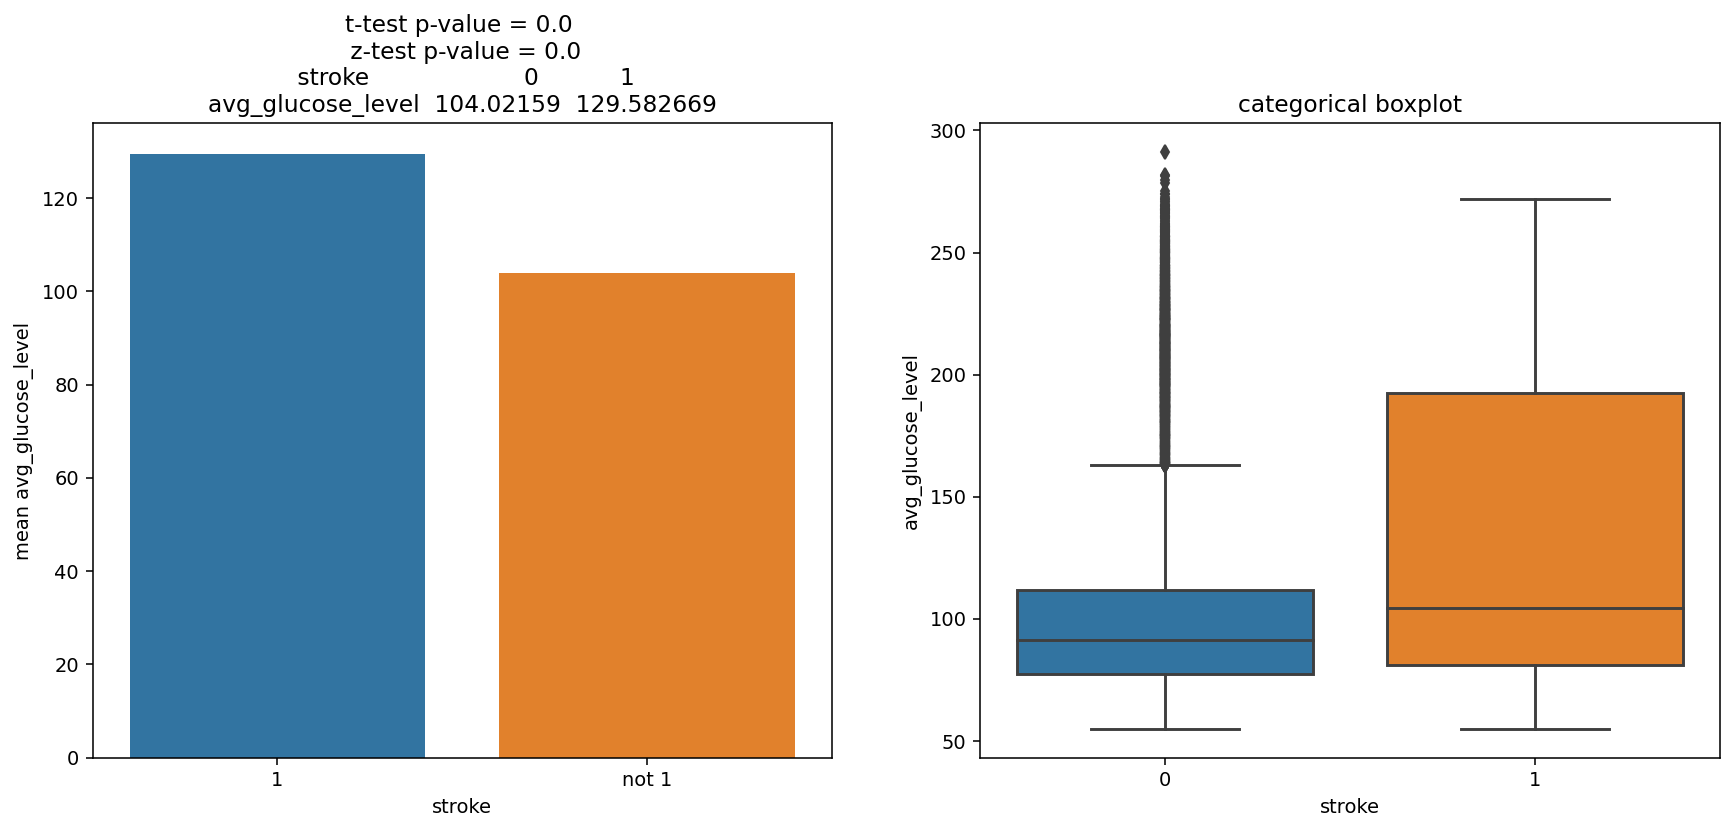

In [33]:
Bivariate_cont_cat(train, 'avg_glucose_level', 'stroke', 1)

Higher glucose levels is signficant for a stroke. We can also see outliers for those who do not have a stroke but also have high glucose levels.

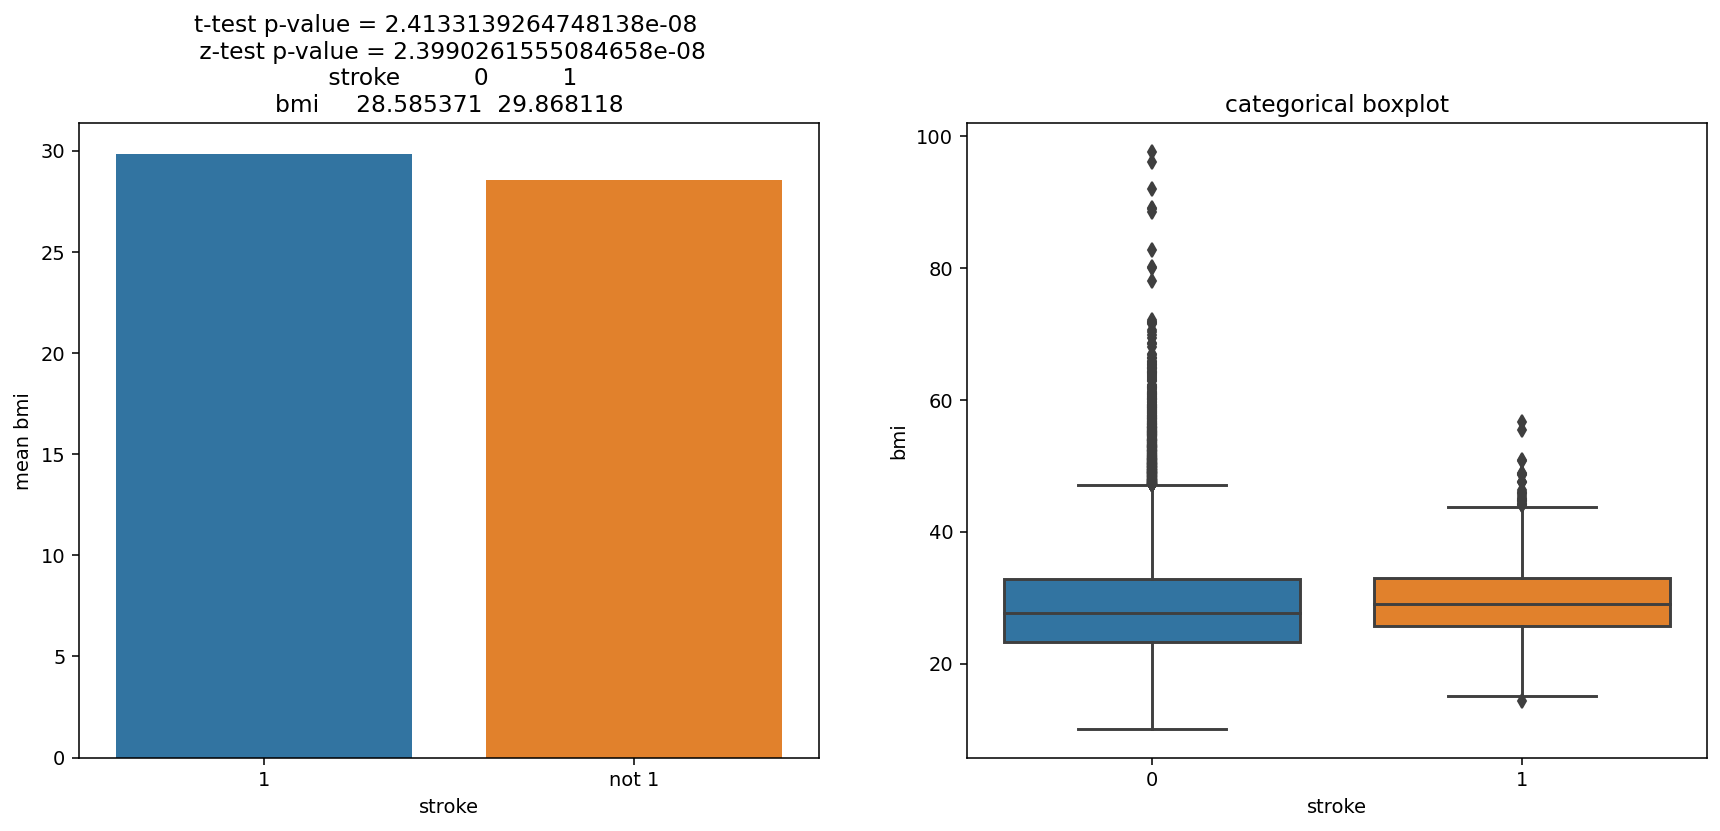

In [34]:
Bivariate_cont_cat(train, 'bmi', 'stroke', 1)

BMI is also statistically signficant. Also outliers for higher bmi and no stroke.

## Multivariate Analysis

In [35]:
train.pivot_table('stroke', ['gender', 'hypertension'], 'work_type', aggfunc='mean')*100

work_type            Govt_job  Never_worked   Private  Self-employed  children
gender hypertension                                                           
Female 0             1.503006           0.0  1.293475       2.569343  0.067204
       1             4.088050           NaN  4.018196       8.130081  0.000000
Male   0             1.188547           0.0  1.837977       3.917254  0.000000
       1             3.272727           0.0  4.857143       4.989605  0.000000
Other  0             0.000000           NaN  0.000000            NaN  0.000000

In [36]:
train.pivot_table('stroke', ['gender', 'smoking_status'], 'work_type', aggfunc='mean')*100

work_type               Govt_job  Never_worked   Private  Self-employed  \
gender smoking_status                                                     
Female formerly smoked  2.666667           0.0  1.799387       4.127358   
       never smoked     1.519155           0.0  1.575600       3.581267   
       smokes           1.526718           0.0  1.606583       2.684564   
Male   formerly smoked  1.632653           0.0  3.723932       4.926108   
       never smoked     1.673102           0.0  1.274066       3.251121   
       smokes           0.909091           0.0  2.409021       3.526971   
Other  formerly smoked  0.000000           NaN  0.000000            NaN   
       never smoked          NaN           NaN  0.000000            NaN   
       smokes                NaN           NaN  0.000000            NaN   

work_type               children  
gender smoking_status             
Female formerly smoked       0.0  
       never smoked          0.0  
       smokes                0.0  
Male   formerly smoked       0.0  
       never smoked          0.0  
       smokes                0.0  
Other  formerly smoked       0.0  
       never smoked          NaN  
       smokes                NaN

In [37]:
train.pivot_table('stroke', ['gender', 'ever_married'], 'work_type', aggfunc='mean')*100

work_type            Govt_job  Never_worked   Private  Self-employed  children
gender ever_married                                                           
Female No            0.789889           0.0  0.548125       2.707581  0.067182
       Yes           1.978350           0.0  1.948660       3.528399       NaN
Male   No            0.802139           0.0  0.755002       2.770083  0.000000
       Yes           1.598174           0.0  2.707763       4.306020       NaN
Other  No                 NaN           NaN  0.000000            NaN  0.000000
       Yes           0.000000           NaN  0.000000            NaN       NaN

Keytakeaway from above:
* female, hypertension, and self-employed seemed to have the highest percentage of a stroke.
* both male and female who formerly smoked and are self-employed seemed to have higher percentage of stroke!
* self-employed, married, and either feamil or femail have 3.5% to 4.3% - so higher chances.

In any event, we need to def keep the work_type feature, gender, hypertension features!

# Data Preprocessing/Cleaning/Feature Selection
* This notebook is quickly getting large! Offloaded prerpocessing to preprocess.py (please see file)
* Will concentrate on the dataframes returned by script and model building.

In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette()

%matplotlib inline
# !pip install jupyterlab
# debugging imports
from IPython.display import Image
from IPython import embed
import pdb
!pip install imblearn
# run the python script - helper scrtip
!python preprocess.py

[INFO] preprocessing script...Baseline preprocessing (minimal)
Only imputed NaNs and LabelEncoded strings categorical features
Imputing bmi with mean value: 28.587098818976564
Imputing smoking_status with mode value: never smoked
[INFO] preprocessing script...Fully preprocessed
Imputed NaNs and LabelEncoded strings categorical features. Also added feature engineering


In [40]:
# from preprocessing script
train_base, test_base = pd.read_csv('train_base.csv'), pd.read_csv('test_base.csv') 
train_full, test_full = pd.read_csv('train_full.csv'), pd.read_csv('test_full.csv') 


In [41]:
target_base, target_full = train_base['stroke'], train_full['stroke']
                
dftrain_base = train_base.drop(['id', 'stroke', 'ever_married'], axis = 1)
dftest_base = test_base.drop(['id', 'stroke', 'ever_married'], axis = 1)

dftrain_full = train_full.drop(['id', 'stroke', 'ever_married'], axis = 1)
dftest_full = test_full.drop(['id', 'stroke', 'ever_married'], axis = 1)

In [42]:
dftrain_base.head() # bare minimum preprocess here.

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,3.0,0,0,4,0,95.12,18.0,1
1,1,58.0,1,0,2,1,87.96,39.2,1
2,0,8.0,0,0,2,1,110.89,17.6,1
3,0,70.0,0,0,2,0,69.04,35.9,0
4,1,14.0,0,0,1,0,161.28,19.1,1


# Model Building & Cross Validation

In [43]:
dftrain_full.head() # fully preprocessed and also introduced a couple of new features. Please review prprocess.py for more details.
models = {} # dictionary to store logistic regression models for auc-roc comparison.

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
    train_test_split(dftrain_base, target_base,
                     test_size=0.20,
                     stratify=target_base,
                     random_state=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((34720, 9), (8680, 9), (34720,), (8680,))

In [45]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,classification_report,roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

#Model function
def model_train_eval(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):
    
    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    # embed()
    print ("ROC-AUC score : ", roc_auc_score(dtest_Y, predictions))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    return roc_auc_score(dtest_Y, predictions)

In [46]:
lr_base= LogisticRegression()
# lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.2, 1: 0.8}) # using class_weights param
models['base_model'] = [ lr_base ,model_train_eval(lr_base,X_train,y_train,X_valid,y_valid,X_train.columns)]

LogisticRegression()
ROC-AUC score :  0.5
classification report :
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      8680
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98      8680
   macro avg       0.50      0.49      0.50      8680
weighted avg       1.00      0.98      0.99      8680



In [47]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(dftrain_full, target_full,
                     test_size=0.20,
                     stratify=target_full,
                     random_state=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((34720, 15), (8680, 15), (34720,), (8680,))

In [48]:
lr_full= LogisticRegression(solver='newton-cg', class_weight='balanced')
# lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.2, 1: 0.8}) # using class_weights param
models['fully_preprocessed_class_weight'] = [ lr_full ,model_train_eval(lr_full,X_train,y_train,X_valid,y_valid,X_train.columns)]

LogisticRegression(class_weight='balanced', solver='newton-cg')
ROC-AUC score :  0.8035304993382463
classification report :
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      6335
         1.0       0.87      0.06      0.11      2345

    accuracy                           0.74      8680
   macro avg       0.80      0.53      0.48      8680
weighted avg       0.77      0.74      0.65      8680



## Internal Cross Validation (AUC-ROC)

In [49]:
def k_fold_cross_valid(lr, dftrain, target, i, title):
    for train,test in cv.split(dftrain, target):
        prediction = lr.fit(dftrain.iloc[train],target.iloc[train]).predict_proba(dftrain.iloc[test])
        # embed()
        fpr, tpr, t = roc_curve(target[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' ROC')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    # plt.savefig('foo.png')
    plt.show()

    print(f'Features used: {dftrain.columns}')

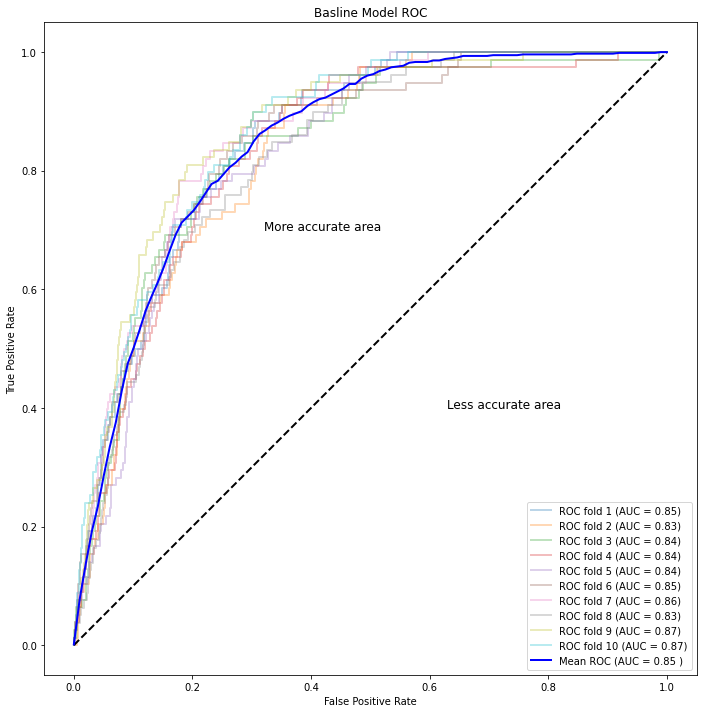

Features used: Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
      dtype='object')


In [50]:
from scipy import interp
cv = StratifiedKFold(n_splits=10, shuffle=False) # 10 folds 

fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

k_fold_cross_valid(models['base_model'][0], dftrain_base, target_base, 1, "Basline Model")


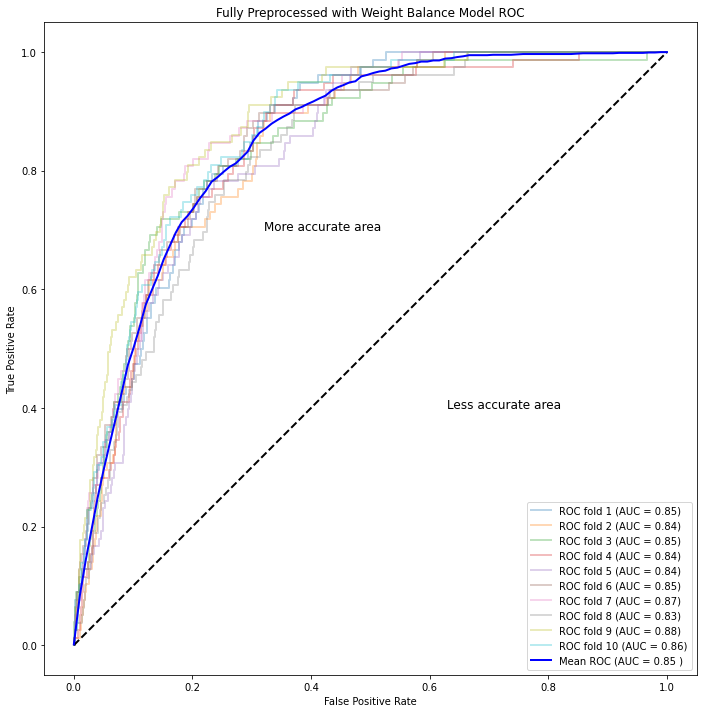

Features used: Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'diabetic_ranges', 'obesity_indicator', 'age_group',
       'critical_condition', 'avg_glucose_level_log', 'bmi_log'],
      dtype='object')


In [51]:
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
k_fold_cross_valid(models['fully_preprocessed_class_weight'][0], dftrain_full, target_full, 1, "Fully Preprocessed with Weight Balance Model")

## Dealing with Data Imbalance 
* reading here: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
* We will attempt two techniques in this notebook. 
1. Sampling (oversampling of the minority class)
2. Algo method - Logistic Regression weights.

Up to this point we have only tried the algo method for balanced weights. next we will try oversampling.

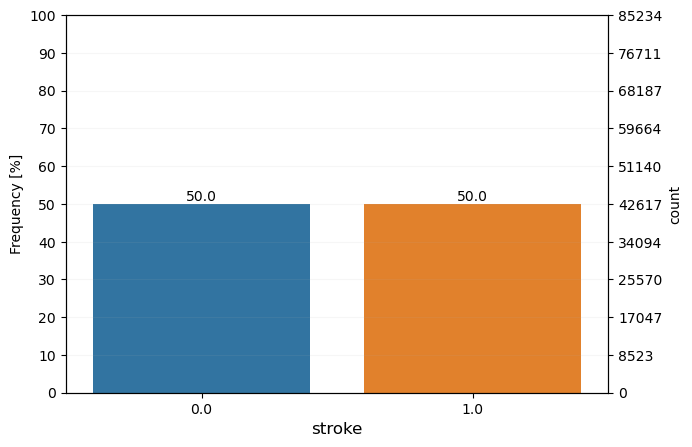

In [52]:
from imblearn.over_sampling import RandomOverSampler
from utils import EDA_category

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(train_full, train_full['stroke'])
EDA_category(X_ros,['stroke'])

In [53]:
dftrain_ros = X_ros.drop(['id', 'stroke', 'avg_glucose_level_log', 'bmi_log'], axis = 1)
dftest_ros = test_full.drop(['id', 'stroke', 'avg_glucose_level_log', 'bmi_log'], axis = 1)
X_train, X_valid, y_train, y_valid = \
    train_test_split(dftrain_ros, y_ros,
                     test_size=0.20,
                     stratify=y_ros,
                     random_state=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((68187, 14), (17047, 14), (68187,), (17047,))

In [54]:
lr_ros= LogisticRegression(solver='newton-cg', class_weight='balanced')
# lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.2, 1: 0.8}) # using class_weights param
models['lr_ros'] = [lr_ros ,model_train_eval(lr_ros,X_train,y_train,X_valid,y_valid,X_train.columns)]

LogisticRegression(class_weight='balanced', solver='newton-cg')
ROC-AUC score :  0.7733894051445415
classification report :
               precision    recall  f1-score   support

         0.0       0.74      0.79      0.77      7998
         1.0       0.80      0.76      0.78      9049

    accuracy                           0.77     17047
   macro avg       0.77      0.77      0.77     17047
weighted avg       0.78      0.77      0.77     17047



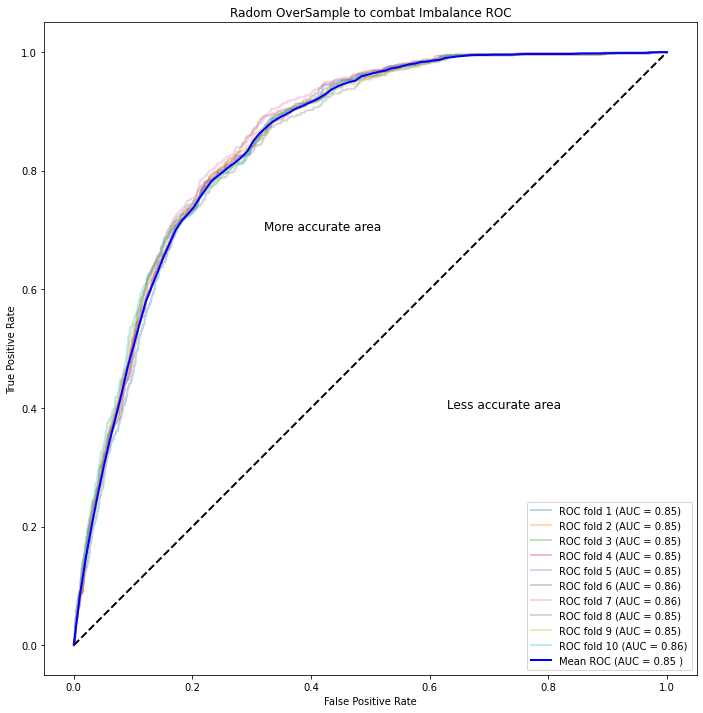

Features used: Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'diabetic_ranges', 'obesity_indicator', 'age_group',
       'critical_condition'],
      dtype='object')


In [55]:
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
k_fold_cross_valid(models['lr_ros'][0], dftrain_ros, y_ros, 1, "Radom OverSample to combat Imbalance")

In [58]:
# add l2 regularization.
lr_ros_elasticnet= LogisticRegression(penalty='elasticnet', solver='saga', class_weight='balanced', l1_ratio=0.75)
models['lr_ros_elasticnet'] = [ lr_ros_elasticnet ,model_train_eval(lr_ros_elasticnet,X_train,y_train,X_valid,y_valid,X_train.columns)]

LogisticRegression(class_weight='balanced', l1_ratio=0.75, penalty='elasticnet',
                   solver='saga')
ROC-AUC score :  0.7733307403551479
classification report :
               precision    recall  f1-score   support

         0.0       0.74      0.79      0.77      7997
         1.0       0.80      0.76      0.78      9050

    accuracy                           0.77     17047
   macro avg       0.77      0.77      0.77     17047
weighted avg       0.78      0.77      0.77     17047



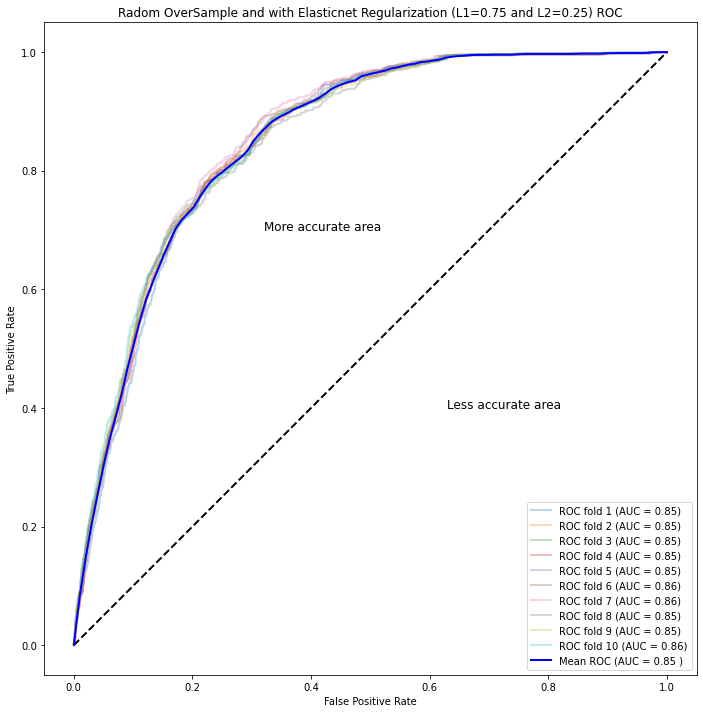

Features used: Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'diabetic_ranges', 'obesity_indicator', 'age_group',
       'critical_condition'],
      dtype='object')


In [59]:
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
k_fold_cross_valid(models['lr_ros_elasticnet'][0], dftrain_ros, y_ros, 1, "Radom OverSample and with Elasticnet Regularization (L1=0.75 and L2=0.25)")

## Final Features Used

In [60]:
dftrain_ros.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'diabetic_ranges', 'obesity_indicator', 'age_group',
       'critical_condition'],
      dtype='object')

## Model building Summary
* Ended up with 3 models, i.e.
1. Baseline model (with minimum preprocessing, just labeleconding)
2. Fully preprocessed plus feature engineering + weight balance to fight imbalance target, i.e. added additional features
3. number 2 plus random oversampling to furhter fight against imbalance target (hopeful this one is the best for submission)

In [61]:
models

{'base_model': [LogisticRegression(), 0.5],
 'fully_preprocessed_class_weight': [LogisticRegression(class_weight='balanced', solver='newton-cg'),
  0.8035304993382463],
 'lr_ros': [LogisticRegression(class_weight='balanced', solver='newton-cg'),
  0.7733894051445415],
 'lr_ros_elasticnet': [LogisticRegression(class_weight='balanced', l1_ratio=0.75, penalty='elasticnet',
                     solver='saga'),
  0.7733307403551479]}

## Sequential feature selection algorithms
Prashant unvieled this cool technique and archived his code for our use.

In [62]:
from sklearn.base import clone
from itertools import combinations
# used classes created by Prashant and changed scoring to our purpose, i.e. AUC ROC
class SBS():
    def __init__(self, estimator, k_features, scoring=roc_auc_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        # pdb.set_trace()
        while dim > self.k_features:
            scores = []
            subsets = []
            # picking combinations of the features and scoring on them and decrementing features by 1 every time.
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            # taking the best score from the combinations per this round of dim.
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # embed()
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [63]:
X, y = dftrain_full.values, target_full.values
X.shape, y.shape

((43400, 15), (43400,))

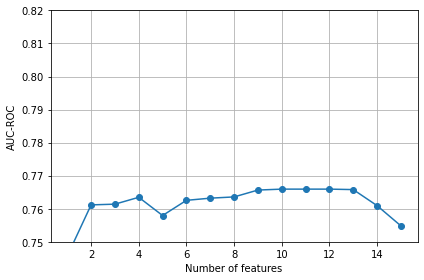

In [64]:
# selecting features - brute force it with  your likely best model
sbs = SBS(models['lr_ros'][0], k_features=1)
# pdb.set_trace()
sbs.fit(X, y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.75, 0.82])
plt.ylabel('AUC-ROC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [65]:
sbs.subsets_
k10 = list(sbs.subsets_[5]) # if chosen 9 features.
print(dftrain_full.columns[k10])

Index(['age', 'hypertension', 'heart_disease', 'work_type', 'Residence_type',
       'avg_glucose_level', 'smoking_status', 'obesity_indicator', 'age_group',
       'bmi_log'],
      dtype='object')


## Brute Force and testing every feature at Random
* Looks like about 10 features has the best AUC-ROC score.
* Selected features above are almost the same as the ones you selected. Need more time to look into this, no more time.

# Debugging algorithms with learning curves
* Let's have a look at the learning curves to see if there is any indicative overfitting, i.e. gaps between training and validation curves
* We will do this analysis on our best model so far, again that is models['lr_ros'][0], i.e. model with balanced weights and also ROS.

In [66]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=models['lr_ros_elasticnet'][0],
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

In [67]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
train_mean

array([0.78261082, 0.77652571, 0.77520369, 0.77501528, 0.774547  ,
       0.77415263, 0.77320809, 0.77335112, 0.77343159, 0.77297288])

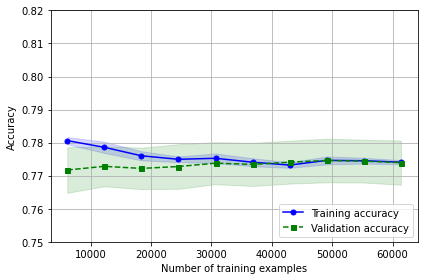

In [186]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.75, 0.82])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

## Keytakeaway from debugging with training and validation curves
* Slightly small gap between the training and validation curves. Expected because sklearn Logistic Regression already has L2 regularization by default.
* Circle back to where model is defined and add some L1 penalty? Have L1 do feature slection for us...
* Or maybe use elastnic for both l1 and l2 goodness!
* Let's check the model parameters to see if they are large.
* good read: https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

In [228]:
dir(models['base_model'][0])
models['base_model'][0].coef_ 

array([[-0.00725646,  0.07056531,  0.24191059,  0.85736181, -0.02323156,
         0.01383999,  0.00400176, -0.00291949, -0.03915078]])

In [230]:
dir(models['fully_preprocessed_class_weight'][0])
models['fully_preprocessed_class_weight'][0].coef_ 

array([[ 0.09377411,  5.78594221,  0.38764807,  0.62009885,  0.03628746,
         0.08339876,  3.57396942, -3.38231659,  0.09400313,  0.0207798 ,
         0.25135431, -0.042615  ,  0.        , -1.43447677,  1.15437364]])

In [187]:
dir(models['lr_ros'][0])
models['lr_ros'][0].coef_ # doesnt look too big.

array([[ 0.12475421,  5.89210711,  0.37043004,  0.67107844,  0.03270122,
         0.04913366,  0.09746021,  0.85288627, -0.23828507,  0.10489397,
        -0.09099597,  0.23137087, -0.0375596 ,  0.        ]])

In [188]:
dir(models['lr_ros_elasticnet'][0])
models['lr_ros_elasticnet'][0].coef_

array([[ 0.12467607,  5.93376767,  0.36926376,  0.66945258,  0.02954633,
         0.04916298,  0.09725934,  0.85187286, -0.22125036,  0.10511236,
        -0.09073864,  0.23174217, -0.03217889,  0.        ]])

Above are the model coeficients.

# Creation of Submission File

In [189]:
# best model is the 3rd one with the class weights and trained on random oversampling data
prediction = models['lr_ros_elasticnet'][0].predict_proba(dftest_ros)
prediction
ss = pd.read_csv('sample_submission_pwrF8gb.csv')
ss['stroke'] = prediction[:,1]
ss.to_csv('pred_lr_ros_balanced_weight_elasticnet.csv', index=False)
ss.head()

,id,stroke
0,36306,0.763039
1,61829,0.874030
2,14152,0.024530
3,12997,0.068072
4,40801,0.534143


# COMPLETE - Learned so much!!! Thanks Analytics Vidhya